# Gamma Ray Bursts

In [20]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_1532\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
T90  = data[6]
T100 = data[12]
F    = data[9]
R    = data[11] 

In [4]:
# Assume T90, T100, F, R are arrays of strings
X = np.vstack([T90, T100, F, R]).T  # Shape: (n_samples, 4)

# Mask rows that do NOT contain the string '-999'
mask = ~np.any(X == '-999', axis=1)

# Keep only clean rows
Y = X[mask]

Y = Y.astype(float)

In [29]:
Y_train, Y_temp = train_test_split(Y, test_size=0.3, random_state=42)
Y_val, Y_test = train_test_split(Y_temp, test_size=0.5, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler = StandardScaler()

In [32]:
scaler.fit(Y_train)
Y_train_transformed = scaler.transform(Y_train)
Y_test_transformed = scaler.transform(Y_test)
Y_val_transformed = scaler.transform(Y_val)

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=4)

In [35]:
pca.fit(Y_train_transformed)

PCA(n_components=4)

In [36]:
pca.explained_variance_ratio_

array([0.51435615, 0.25584288, 0.22258707, 0.00721391])

Thus major part of the variance is contained into the first three dimensions $\to$ T90, T100, fluence. I'll use just these to cluster my data

In [37]:
A_train = pca.transform(Y_train_transformed)  # oppure [:2] per visualizzazione
A_test  = pca.transform(Y_test_transformed)
A_val  = pca.transform(Y_val_transformed)

In [38]:
k_range = np.logspace(-2, 0, 10)  # Example: 0.01 to 1
best_score = -1
best_bandwidth = None
scores = []
for bw in k_range:
    ms = MeanShift(bandwidth=bw)
    ms.fit(A_train)
    labels = ms.predict(A_test)
    if len(np.unique(labels)) > 1:
        scores.append(silhouette_score(A_test, labels))

Text(0.5, 1.0, 'Hyperparameter tuning')

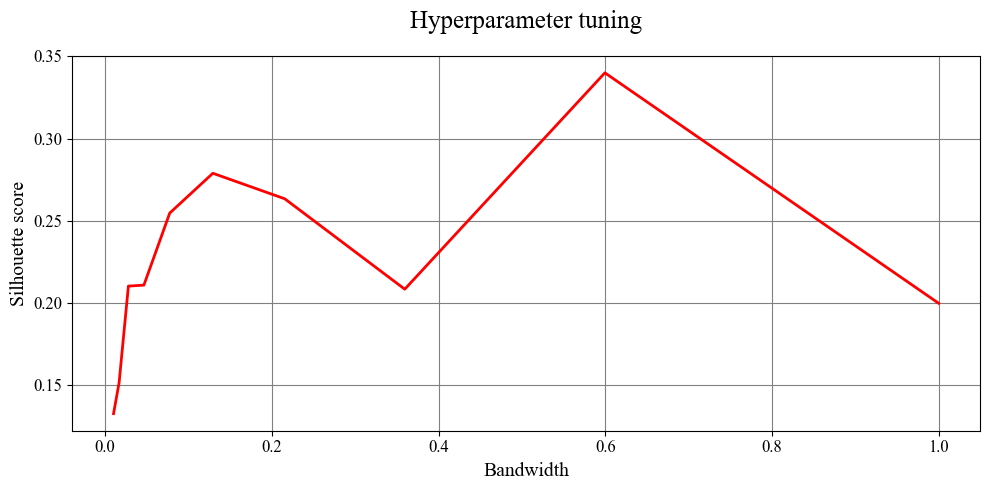

In [39]:
plt.plot(k_range, scores, lw=2, color='red')
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette score')
plt.title('Hyperparameter tuning')

In [43]:
ms = MeanShift(bandwidth=k_range[np.argmax(scores)])
ms.fit(A_train)
labels = ms.predict(A_test)

In [44]:
A = np.vstack([A_train, A_test])

In [47]:
# Inverti PCA + StandardScaler
Y_reconstructed = pca.inverse_transform(A_test)
Y_original_space = scaler.inverse_transform(Y_reconstructed)

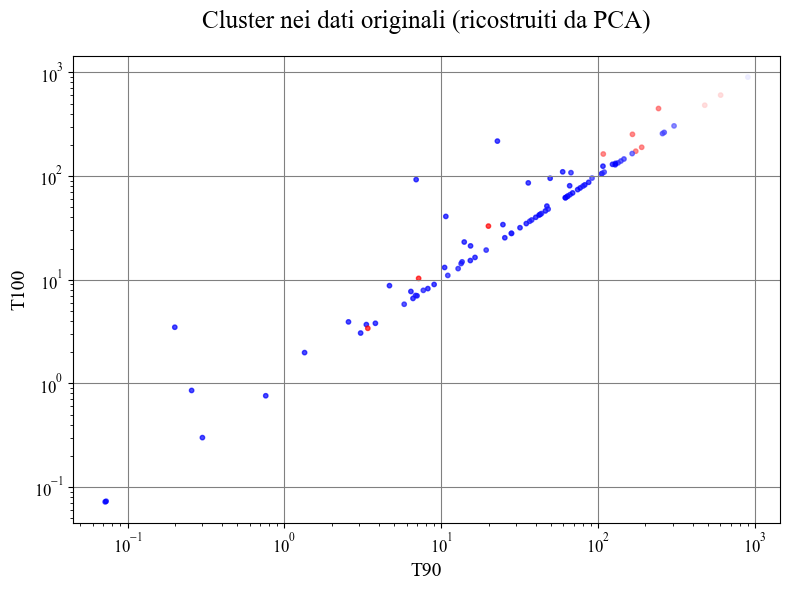

In [48]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 1],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("T100")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

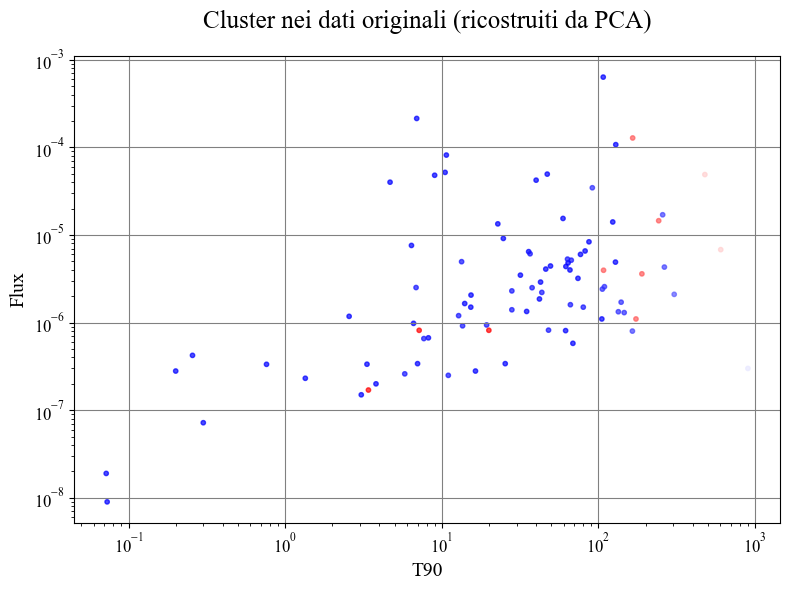

In [49]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 2],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("Flux")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

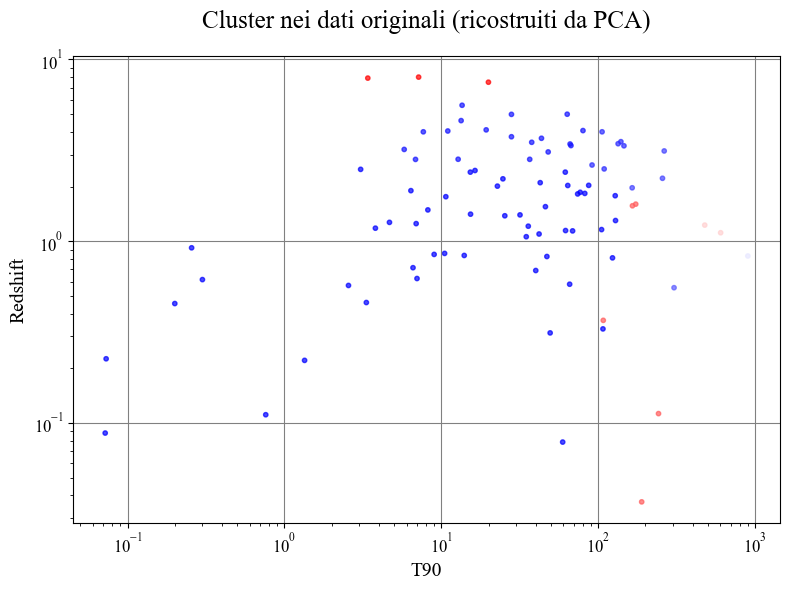

In [50]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 3],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("Redshift")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

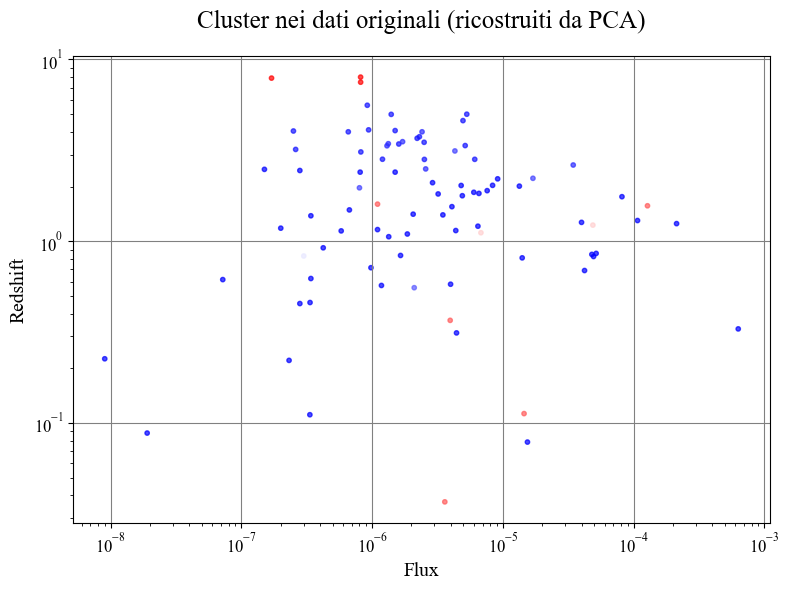

In [51]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 2],  # ad esempio T90
    Y_original_space[:, 3],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("Flux")
plt.ylabel("Redshift")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()